In [21]:
from bs4 import BeautifulSoup
import lxml
import re
import lxml.etree
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
import string
import pandas as pd 
import numpy as np
from nltk.tag import pos_tag
from sklearn.model_selection import train_test_split
import sys
from nltk.stem import PorterStemmer

sys.setrecursionlimit(10**6)

questions = pd.read_csv("C:/Users/manar/nlp project/archive/Questions.csv",encoding="ISO-8859-1")
tags = pd.read_csv("C:/Users/manar/nlp project/archive/Tags.csv",encoding="ISO-8859-1", dtype={'Tag': str})

questions.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)
#no nan values

questions['Body'] = questions['Body'].astype(str)
questions['Title'] = questions['Title'].astype(str)
tags['Tag'] = tags['Tag'].astype(str)

questions = questions.dropna(axis=0, how="all")
tags.drop_duplicates(inplace = True)
tags = tags.dropna(subset = ['Tag'])


#print(tags.isna().sum())
group_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))
group_tags.reset_index()
group_tags_final = pd.DataFrame({'Id':group_tags.index, 'Tags':group_tags.values})
df = questions.merge(group_tags_final, on='Id')
df.head(5)

df = df[df['Score']>4]   #1 works for tf-idf  
#get list of tags
df['Tags'] = df['Tags'].apply(lambda x: x.split())


def remove_htmltags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def remove_stopWords(text):
    stop_words = set(stopwords.words("english"))
    token = ToktokTokenizer()
    words = token.tokenize(text)
    filter_text = [word for word in words if word.casefold() not in stop_words]
    return ' '.join(map(str, filter_text))

def text_Lemmatizing(text):
    token = ToktokTokenizer()
    lemma = WordNetLemmatizer()
    words = token.tokenize(text)
    tagged_words = pos_tag(words)
    # Remove certain types of words based on their tag
    words = [word for word, tag in tagged_words if tag not in ['PRP', 'PRP$', 'IN']]
    # "v" to put it in verb phrase
    lemmatized_words = [lemma.lemmatize(word).lower() for word in words]
    return ' '.join(map(str, lemmatized_words))


def text_stemming(text):
    # Tokenize the text
    token = ToktokTokenizer()
    words = token.tokenize(text)
    tagged_words = pos_tag(words)
    # Remove certain types of words based on their tag
    words = [word for word, tag in tagged_words if tag not in ['PRP', 'PRP$', 'IN']]
    # Apply Porter stemming algorithm to each word
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word).lower() for word in words]
    
    # Join the stemmed words back together into a string
    return ' '.join(map(str, stemmed_words))


def remove_specialCharacters(text):
    # Define a string of punctuation characters
    punct = string.punctuation  
    # Remove all punctuation characters from the input text
    no_punct = ''.join(char for char in text if char not in punct)   
    return no_punct


def preprocessing(X,root):
    X['Body'] = X['Body'].apply(lambda x: remove_htmltags(x))
    X['Body'] = X['Body'].apply(lambda x: remove_stopWords(x))
    if(root == 1):
        X['Body'] = X['Body'].apply(lambda x: text_Lemmatizing(x))
    else:
        X['Body'] = X['Body'].apply(lambda x: text_stemming(x))


    X['Body'] = X['Body'].apply(lambda x: remove_specialCharacters(x))

    X['Title'] = X['Title'].apply(lambda x: str(x)) 
    X['Title'] = X['Title'].apply(lambda x: remove_specialCharacters(x)) 
    X['Title'] = X['Title'].apply(lambda x: remove_stopWords(x)) 
    if(root == 1):
        X['Title'] = X['Title'].apply(lambda x: text_Lemmatizing(x))
    else:
        X['Title'] = X['Title'].apply(lambda x: text_stemming(x))
    return X

# preprocessing x values , y is already preprocessed

df = preprocessing(df,2)
df['Body']
#stemming

ParserError: Error tokenizing data. C error: out of memory

In [17]:

#get common tags
import nltk 
#if the 'Tags' column contains lists of tags for each row, this line will create a single list containing all the tags from all rows.
all_tags = [item for sublist in df['Tags'].values for item in sublist]
#uses the FreqDist method from nltk to create a dictionary of tag frequencies
keywords = nltk.FreqDist(all_tags)
print(keywords)
# Get most frequent tags by creating a list called 'frequencies_words' containing the 30 most common tags and their frequencies.
def common_tags_number(number):
    frequencies_words = keywords.most_common(number)
    return frequencies_words

frequencies_words = common_tags_number(25)
#creates a list called 'tags_features' containing only the tag names (not their frequencies)
tags_features = [word[0] for word in frequencies_words]
# Drop unnecessary columns at this point
print(tags_features)
def most_common_column(tags):
    """Function to check if tag is in most common tag list"""
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

# Change Tags column into None for questions that don't have a most common tag
df['Tags'] = df['Tags'].apply(lambda x: most_common_column(x))
#replace the empty ones to none
df['Tags'] = df['Tags'].apply(lambda x: x if len(x)>0 else None)
df.dropna(subset=['Tags'], inplace=True)
print(df['Tags'].shape)

df['Tags']

<FreqDist with 19085 samples and 389744 outcomes>
['c#', 'java', 'javascript', 'android', 'python', 'c++', 'php', 'jquery', 'ios', '.net', 'html', 'css', 'c', 'objective-c', 'iphone', 'ruby-on-rails', 'sql', 'asp.net', 'mysql', 'ruby', 'r', 'asp.net-mvc', 'sql-server', 'linux', 'git']
(90605,)


2          [sql, asp.net]
4              [c#, .net]
5                   [c++]
6                  [.net]
7            [sql-server]
                ...      
1263303          [python]
1263337            [java]
1263454             [c++]
1263609         [android]
1263727              [c#]
Name: Tags, Length: 90605, dtype: object

In [18]:

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from gensim.models import Word2Vec
from sklearn.decomposition import NMF
from sklearn.ensemble import IsolationForest

# Define X, y
X1 = df['Body']
X2 = df['Title']
y = df['Tags']

print(len(X1), len(X2), len(y))
def y_encoding(y):
    multilabel_binarizer = MultiLabelBinarizer()
    y_bin = multilabel_binarizer.fit_transform(y)
    return y_bin


#feature extraction methods

#Bag of words
def Bag_of_words(x1,x2):
    # Create a CountVectorizer object
    vectorizer = CountVectorizer(max_df=0.8, max_features=1000 ,stop_words='english')
    X1_bow = vectorizer.fit_transform(x1)
    X2_bow = vectorizer.fit_transform(x2)

    # Concatenate the two sparse matrices
    bow_representation_x = hstack([X1_bow, X2_bow])
    return bow_representation_x

#Term Frequency-Inverse Document Frequency  DONE 
def td_idf(x1,x2):
    vectorizer_X1 = TfidfVectorizer(max_df=0.8, max_features=10000 ,stop_words='english')
    vectorizer_X2 = TfidfVectorizer(max_df=0.8, max_features=10000)

    X1_tfidf = vectorizer_X1.fit_transform(x1)
    X2_tfidf = vectorizer_X2.fit_transform(x2)
    X_tfidf = hstack([X1_tfidf,X2_tfidf])

    return X_tfidf

#Topic modeling (e.g. using Latent Dirichlet Allocation or Non-negative Matrix Factorization) low accuracy
def Topic_modeling(x1,x2):
    # Create a TF-IDF vectorizer
    vectorizer_X1 = TfidfVectorizer(max_df=0.8, max_features=10000 ,stop_words='english')
    vectorizer_X2 = TfidfVectorizer(max_df=0.8, max_features=10000)
    
    X1_tfidf = vectorizer_X1.fit_transform(x1)
    X2_tfidf = vectorizer_X2.fit_transform(x2)
    X_tfidf = hstack([X1_tfidf,X2_tfidf])

    # Train an NMF model on the TF-IDF matrix
    num_topics = 50
    nmf_model = NMF(n_components=num_topics, random_state=0)
    nmf_model.fit(X_tfidf)

    # Get the document-topic matrix
    X_nmf = nmf_model.transform(X_tfidf)
    return X_nmf

# Define multilabel binarizer
y_bin = y_encoding(y)

def feature_extraction(X1,X2,choice):
    if(choice == 1):
        X_total = td_idf(X1,X2)
    elif(choice == 2):
        X_total = Bag_of_words(X1,X2)
    elif(choice == 3):
        X_total = Topic_modeling(X1,X2)
    return X_total

X_total = feature_extraction(X1,X2,1)


print(y_bin.shape)

print(X_total.shape)
x_train, X_test, y_train, y_test = train_test_split(X_total, y_bin, test_size = 0.2, random_state = 0)




90605 90605 90605
(90605, 25)
(90605, 20000)


In [19]:

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))
    print("Recall score: {}".format(recall_score(y_true=y_test, y_pred=y_pred, average='weighted')))
    
    ''' weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). 
    This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.
    '''
    print("Precision score: {}".format(precision_score(y_true=y_test, y_pred=y_pred, average='weighted')))
    #Hamming-Loss is the fraction of labels that are incorrectly predicted, i.e., the fraction of the wrong labels to the total number of labels.
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("F1 score: {}".format(f1_score(y_pred, y_test, average='weighted')))
    print("---")    

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score
from skmultilearn.problem_transform import LabelPowerset
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


print("X_train shape: {}".format(x_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))



from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

#we can use other classifiers as a base estimator
#1- rfc = RandomForestClassifier(n_estimators=100, random_state=0)
c = 2
if(c == 1):
    base_estimator = LinearSVC()
elif(c == 2):
    base_estimator = RandomForestClassifier(n_estimators=100, random_state=0)   #0.6152231972529569
elif(c == 3):
    base_estimator = KNeighborsClassifier(n_neighbors=5)   #0.38994463945059135
elif(c == 4):
    base_estimator = LogisticRegression(max_iter=2000)
elif(c == 5):
    base_estimator = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, alpha=1e-4,solver='sgd', verbose=10, tol=1e-4, random_state=1,learning_rate_init=.1)

sgd = SGDClassifier(n_jobs=-1)
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
clf = LabelPowerset(base_estimator)

clf.fit(x_train, y_train)

y_pred = clf.predict(X_test)
print(y_pred.shape)
print(y_test.shape)

print_score(y_pred, clf)
#done for both td , bag(takes 57min)

X_train shape: (72484, 20000)
X_test shape: (18121, 20000)
y_train shape: (72484, 25)
y_test shape: (18121, 25)


MemoryError: could not allocate 292028416 bytes

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score
from skmultilearn.problem_transform import LabelPowerset
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt


svc = LinearSVC()
sgd = SGDClassifier(n_jobs=-1)
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(svc)
# train
classifier.fit(x_train, y_train)
# predict
predictions = classifier.predict(X_test)
print(predictions.shape)
print(y_test.shape)
#predictions = np.argmax(predictions,axis=1)

print_score(predictions, classifier)



(10484, 25)
(10484, 25)
Clf:  BinaryRelevance
Accuracy score: 0.5499809233117131
Recall score: 0.6469784391132706
Precision score: 0.8157034348148208
Hamming loss: 2.4635635253719954
F1 score: 0.732407042117204
---


NameError: name 'cm' is not defined

In [ ]:
cm_BinaryRelevance = multilabel_confusion_matrix(y_test, predictions)
for i in range(len(cm_BinaryRelevance)):
    fig, axs = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm[i], annot=True, cmap="Blues", fmt="d")
    axs.set_title(f"Class {i+1}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

# Compute the confusion matrix
sns.heatmap(cm.sum(axis=0), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("BinaryRelevance Model")
plt.show()

plt.savefig('BinaryRelevance.jpg')


from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Compute precision, recall and F1-score for each class
report = classification_report(y_test, predictions, output_dict=True)
df = pd.DataFrame(report).transpose()

# Plot a bar chart of the metrics for each class
df[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title('Class-wise Metrics')
plt.xlabel('Class')
plt.ylabel('Score')
plt.savefig('BinaryRelevance-report.jpg')

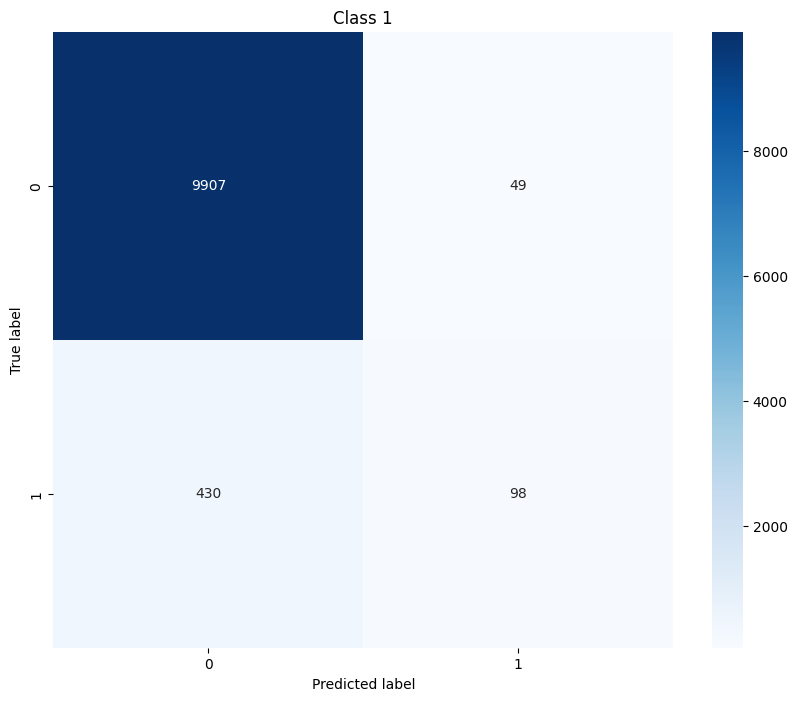

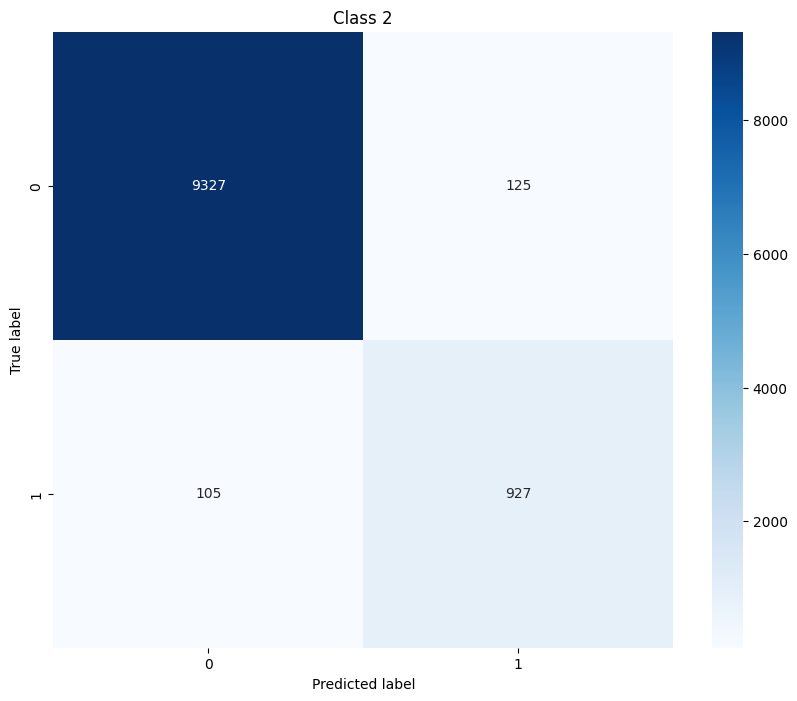

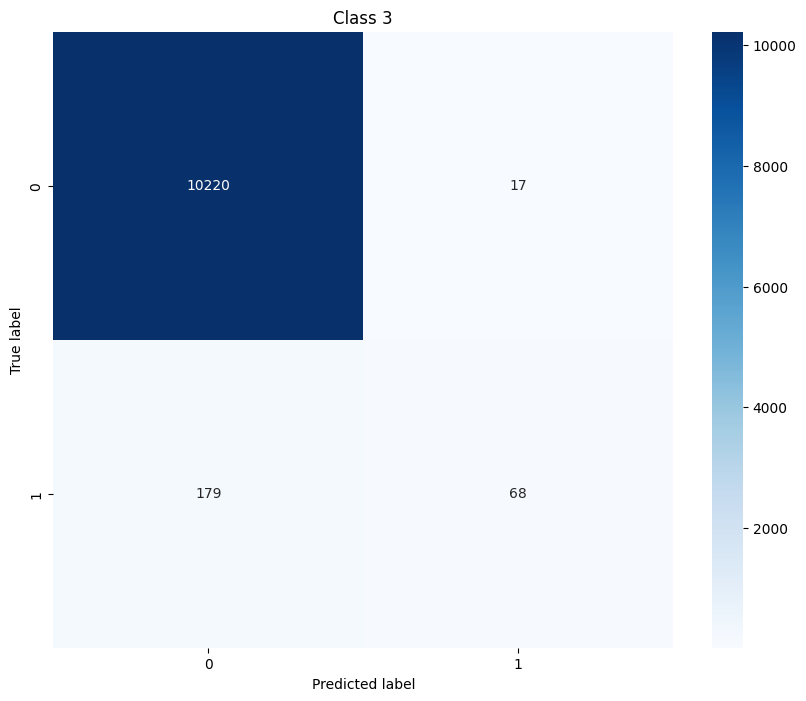

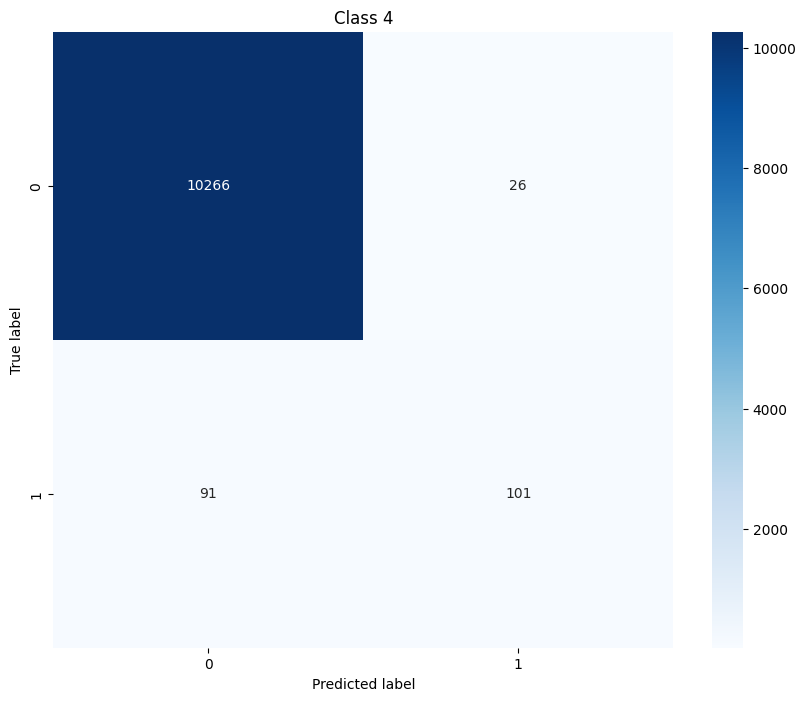

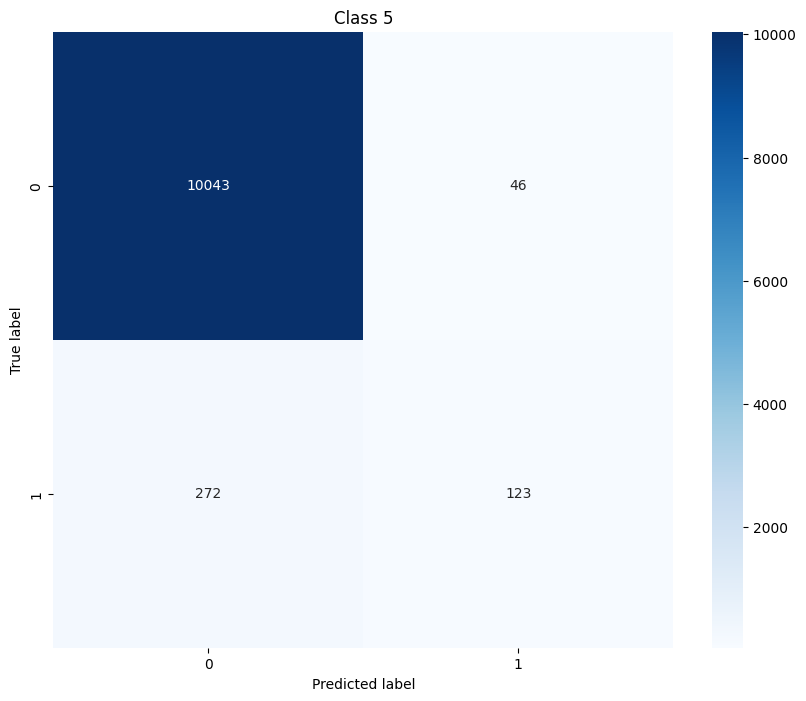

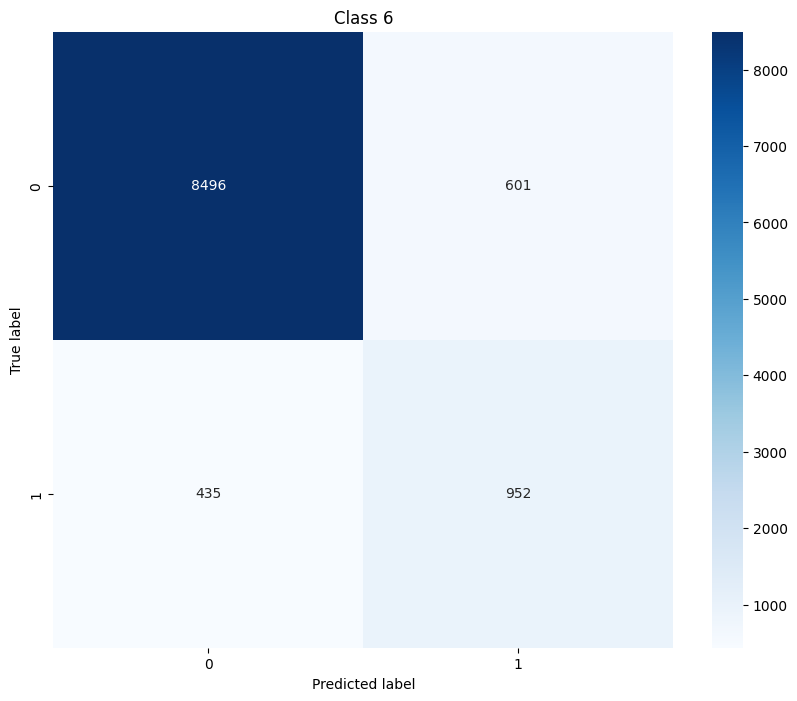

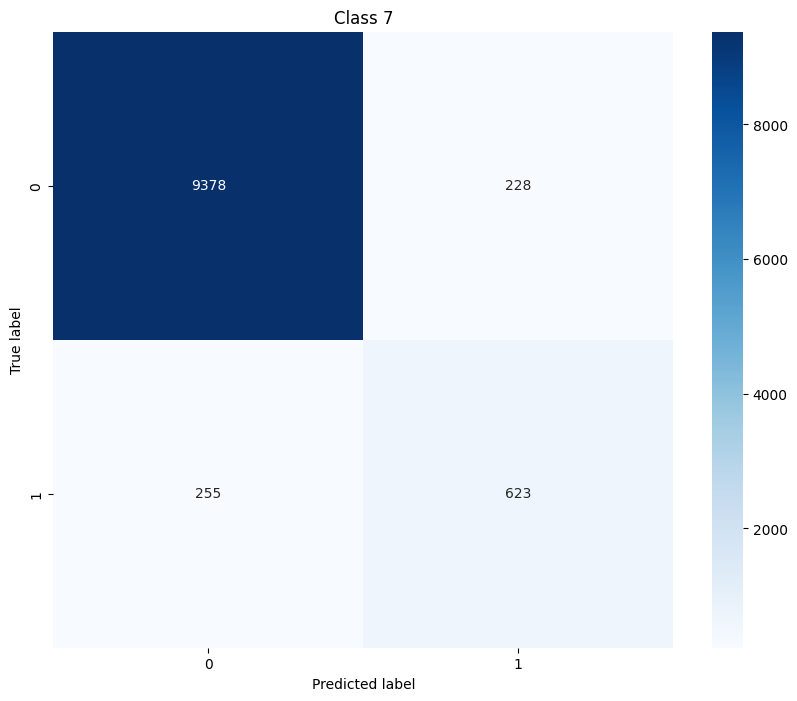

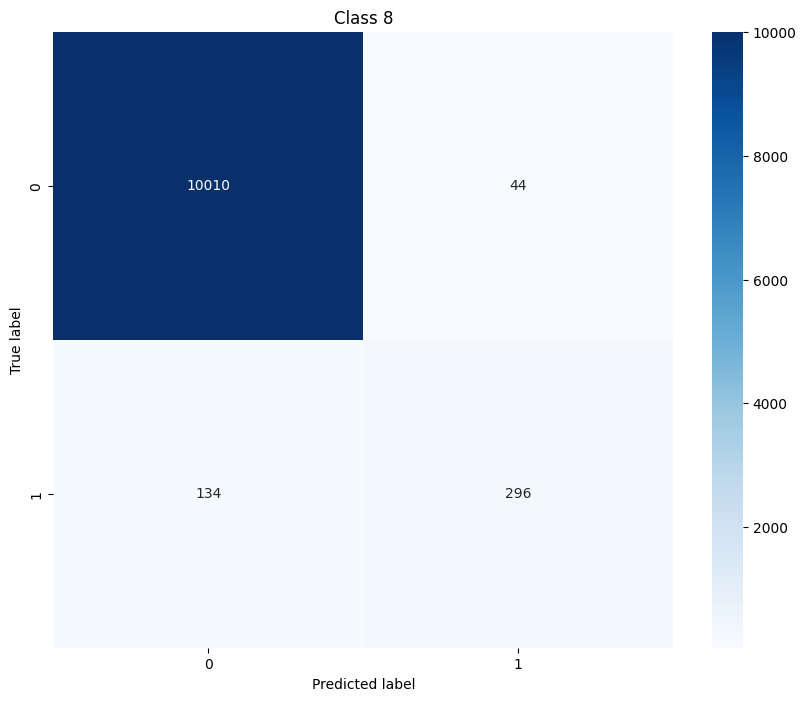

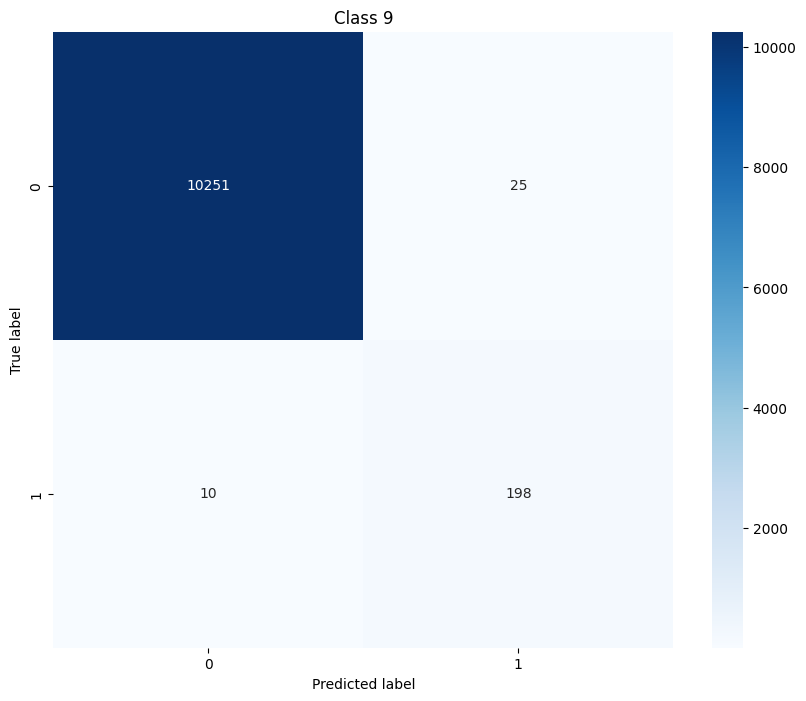

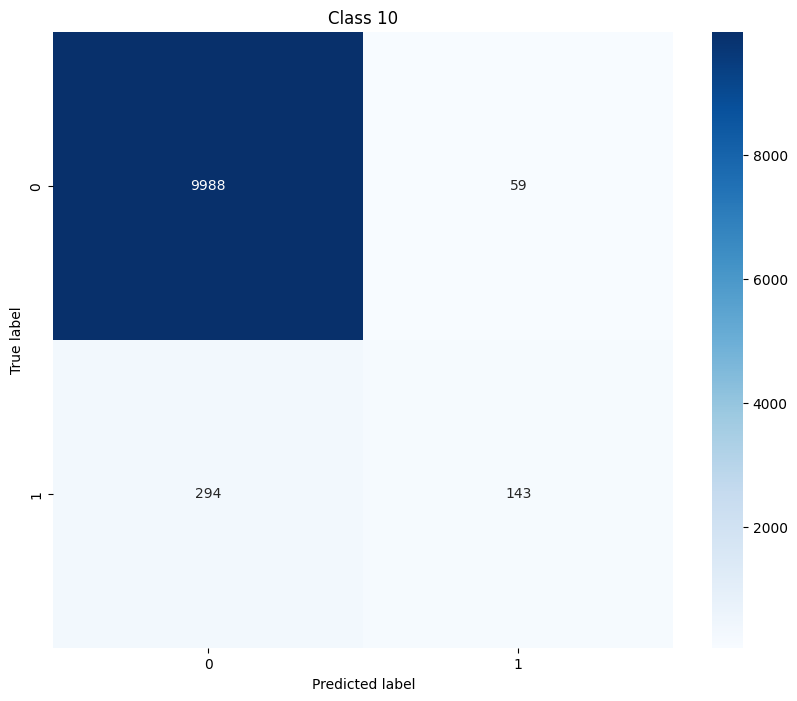

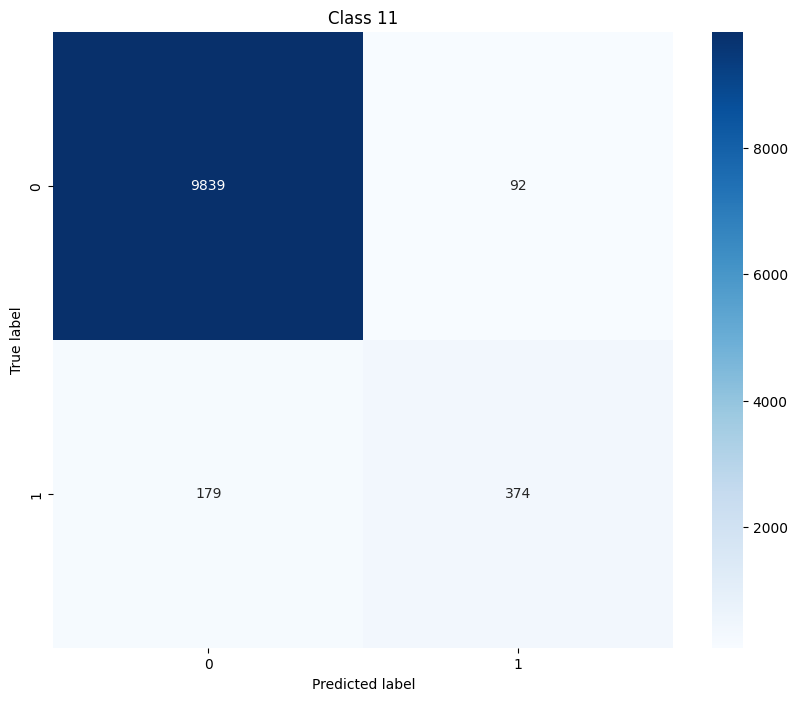

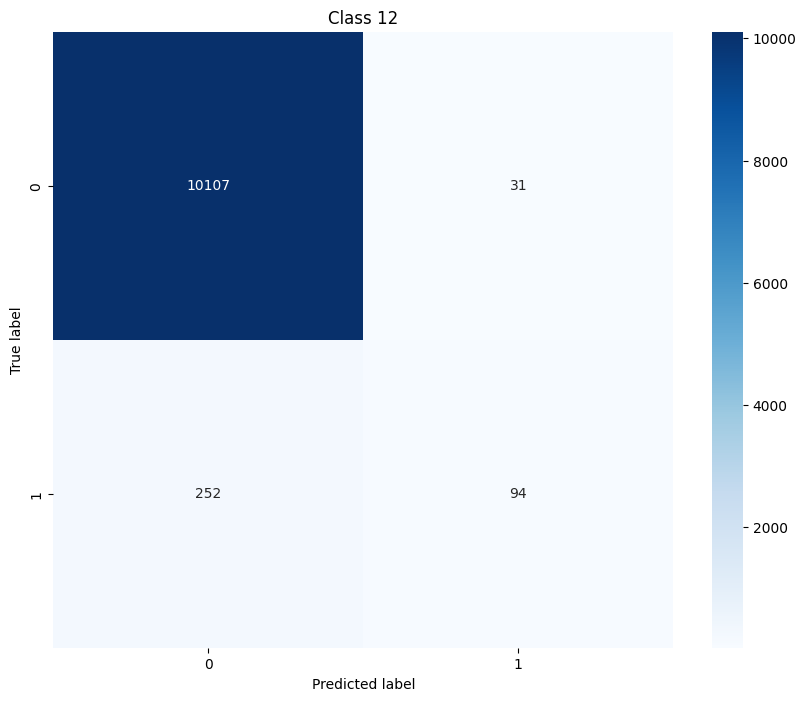

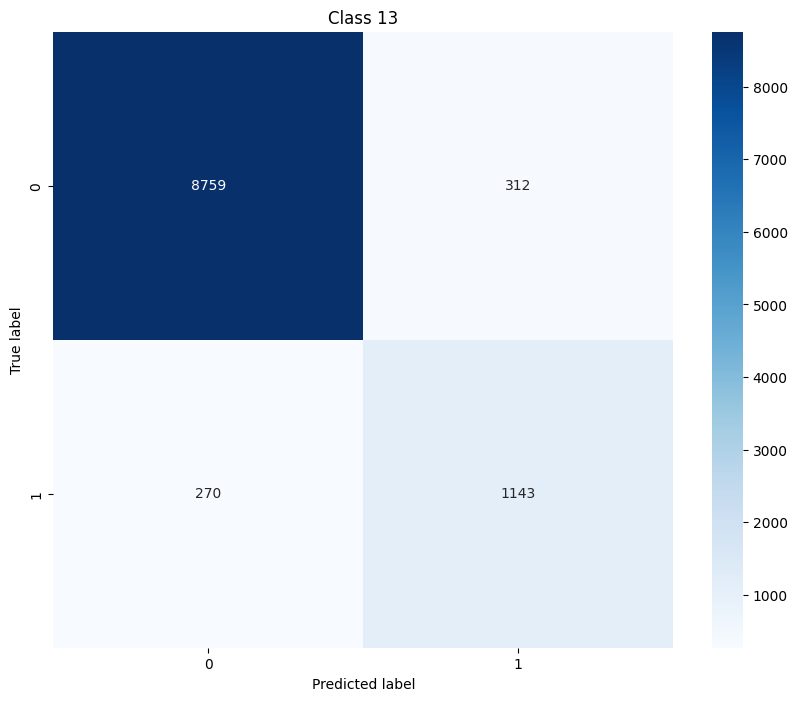

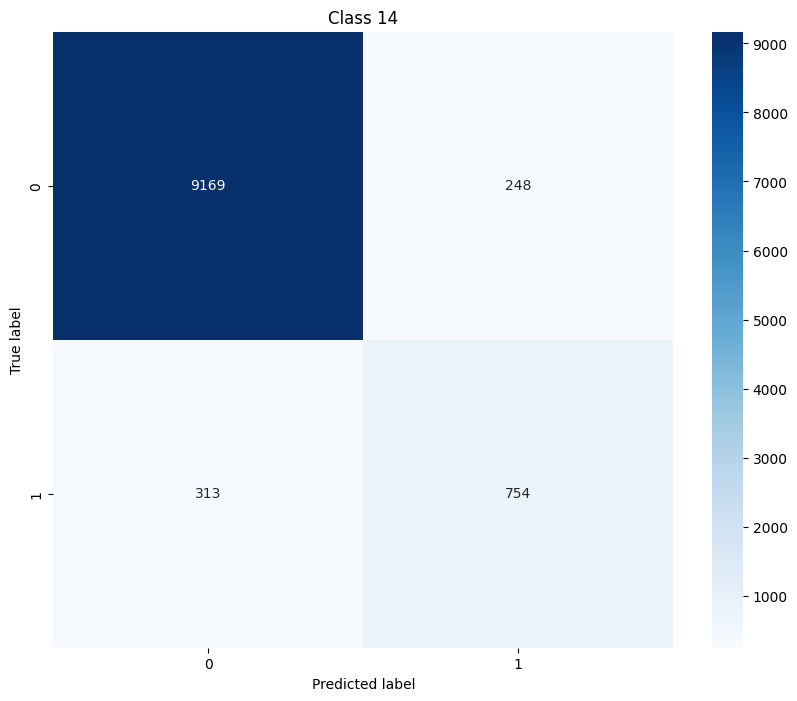

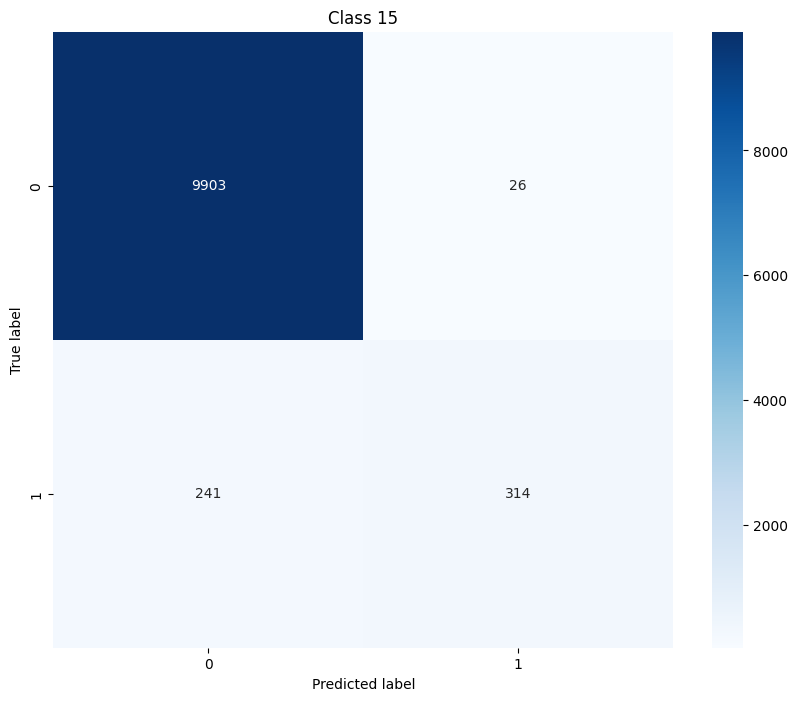

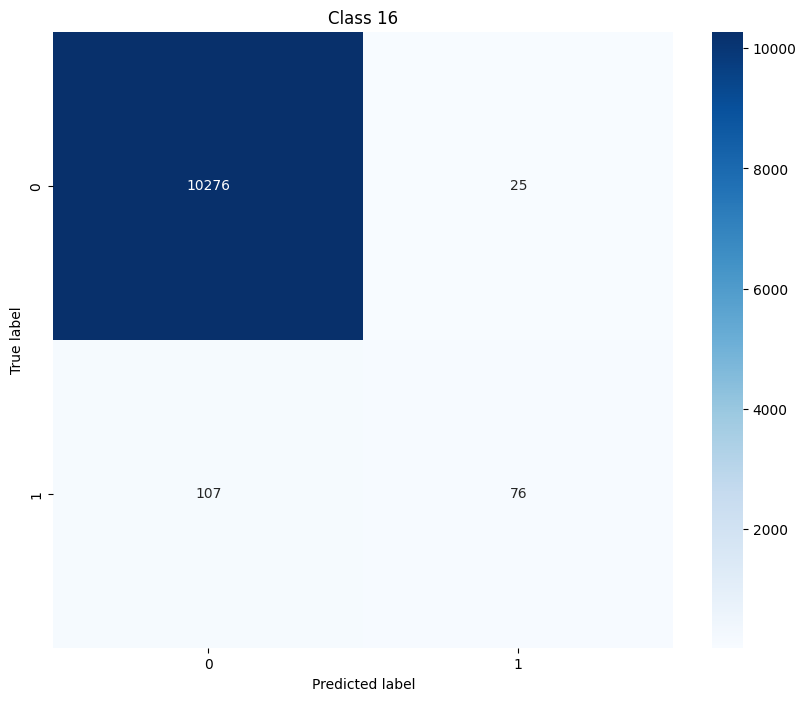

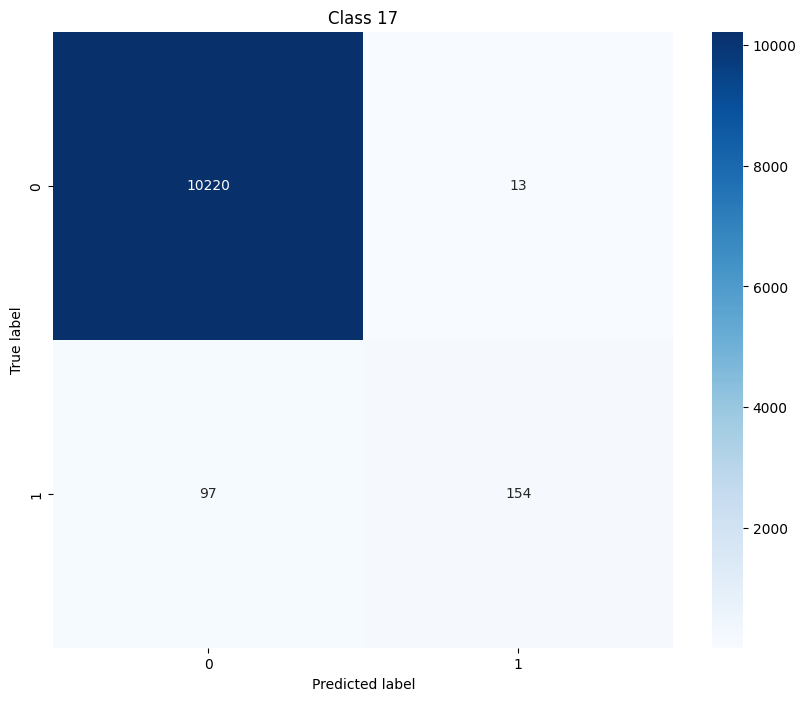

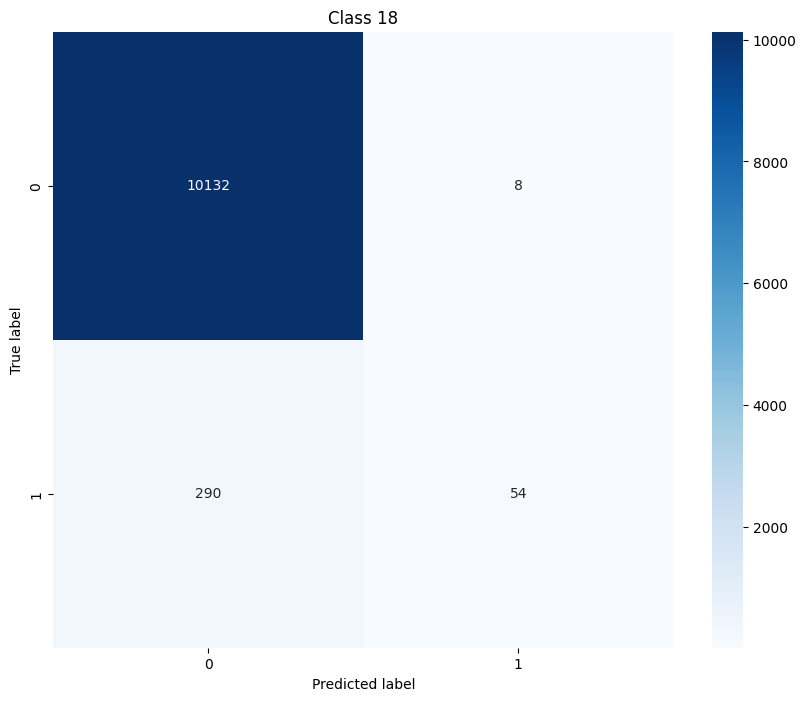

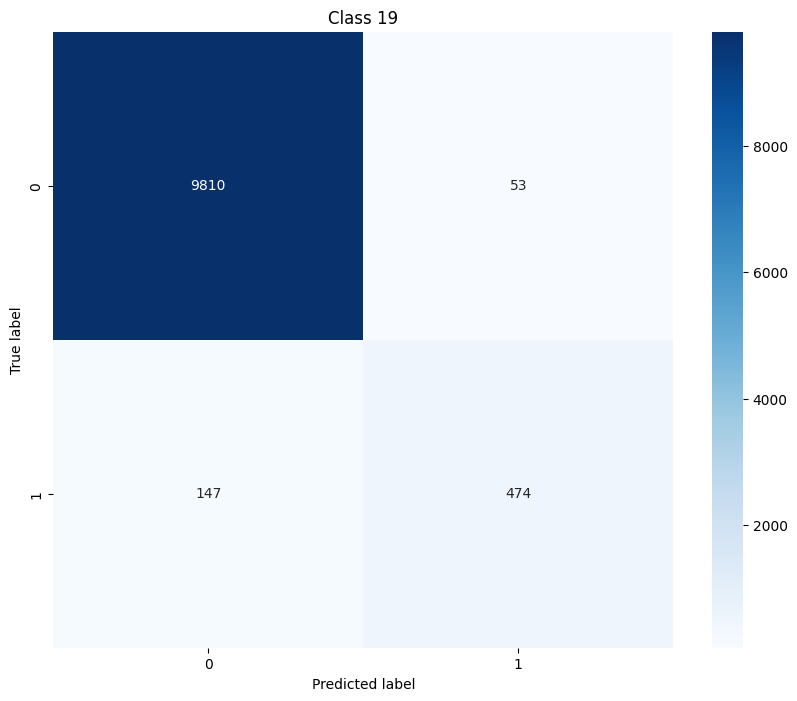

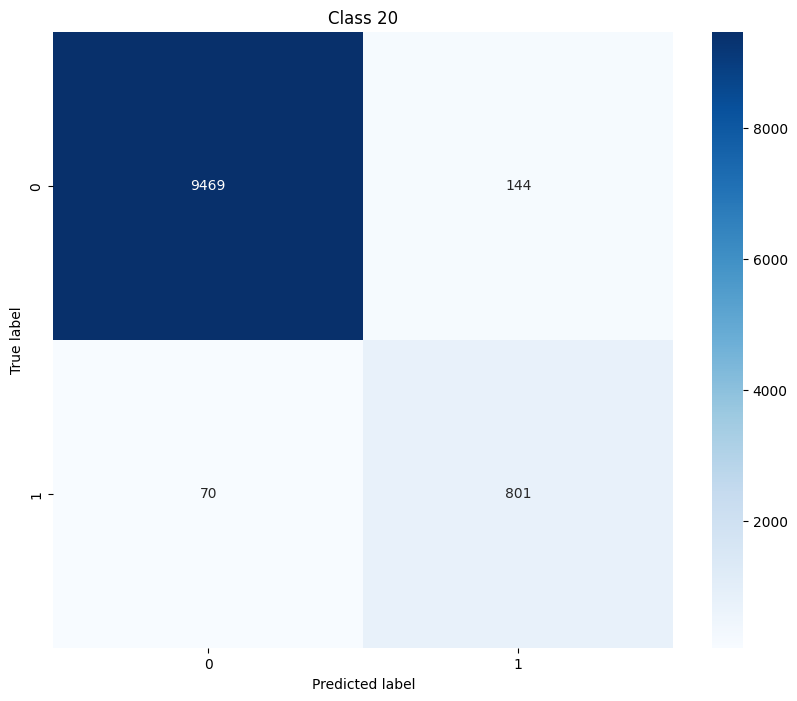

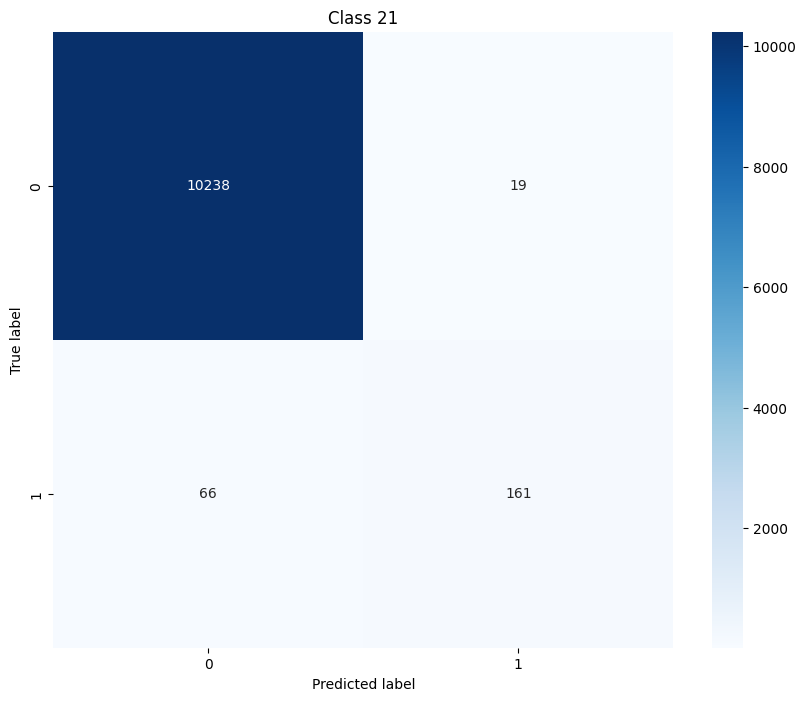

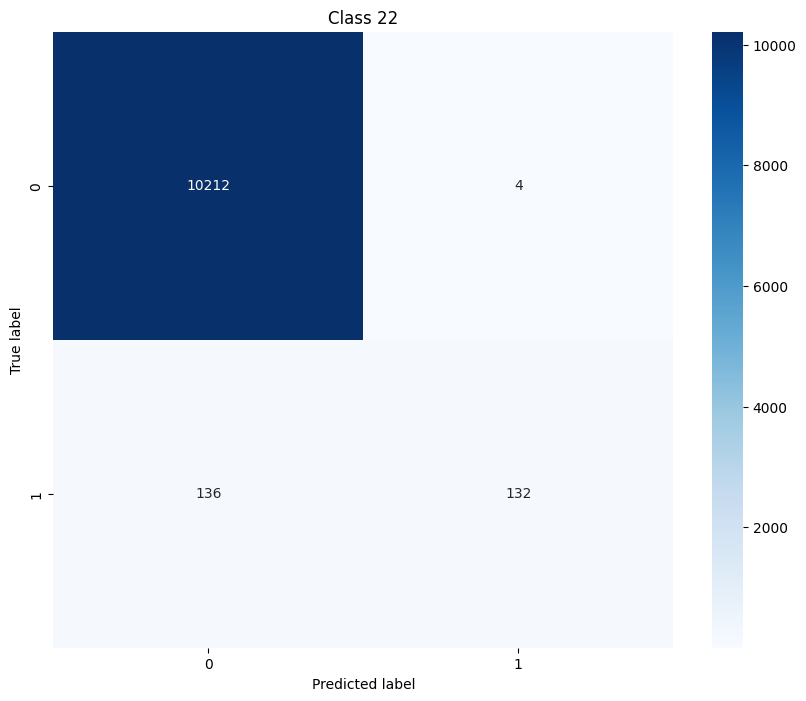

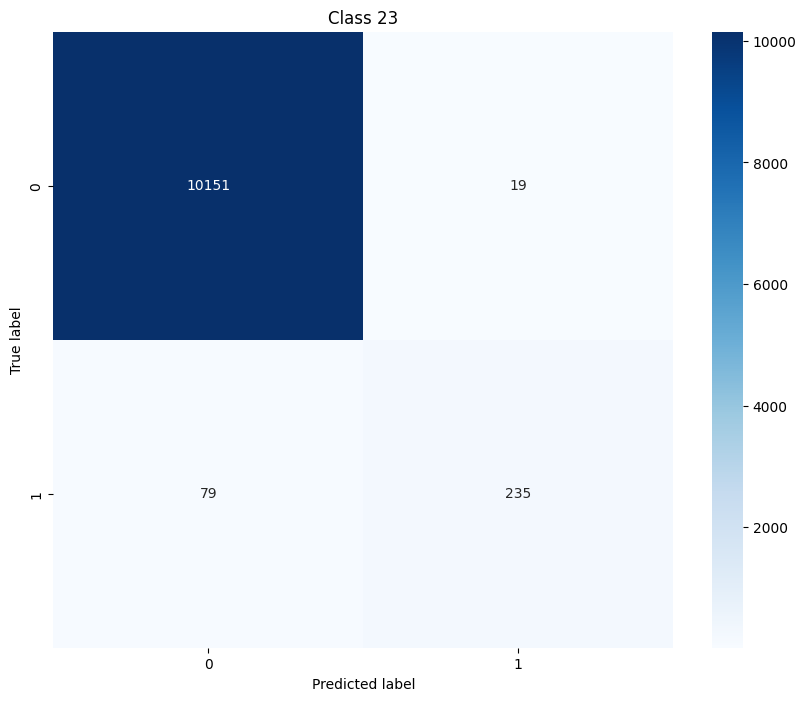

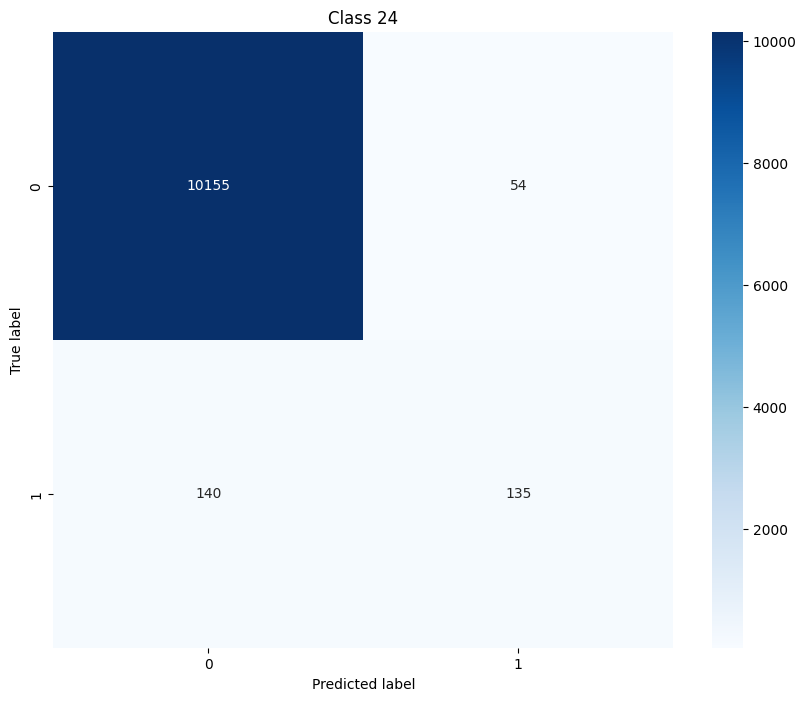

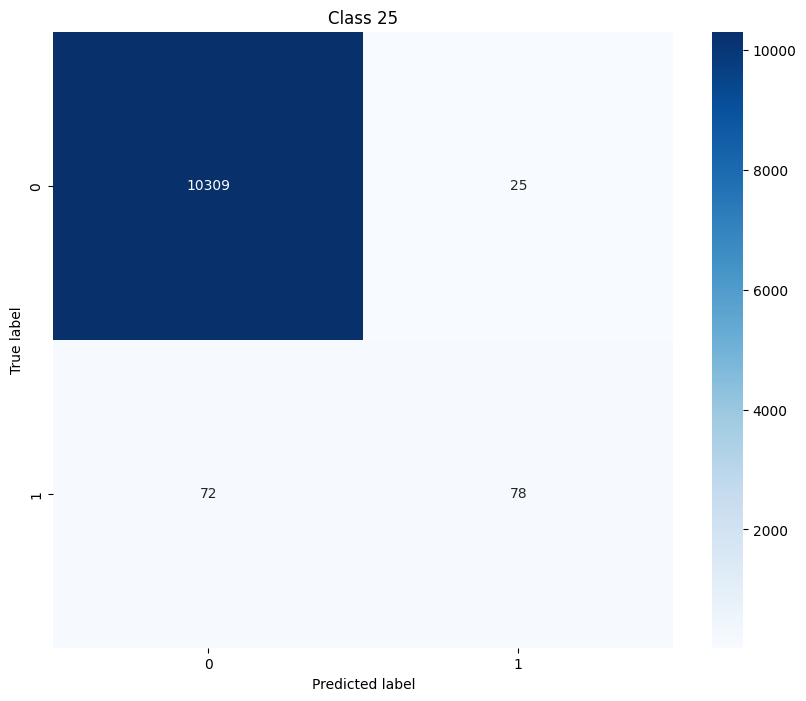

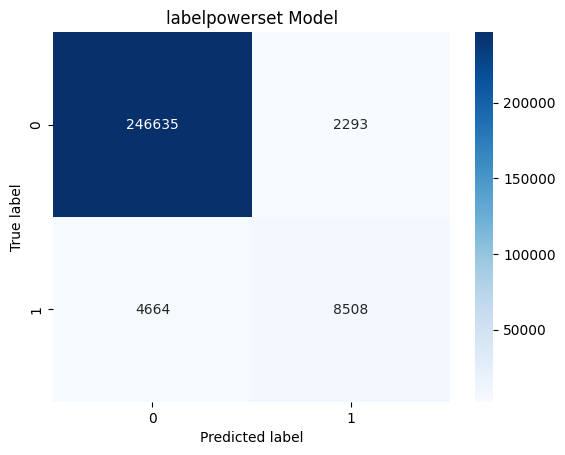

'fig, axs = plt.subplots(ncols=len(cm), figsize=(70, 40))\n\nfor i in range(len(cm)):\n    sns.heatmap(cm[i], annot=True, cmap="Blues", fmt="d", ax=axs[i])\n    axs[i].set_title(f"Class {i+1}")\n    \n# Compute the confusion matrix\nsns.heatmap(cm.sum(axis=0), annot=True, cmap="Blues", fmt="d")\nplt.xlabel("Predicted label")\nplt.ylabel("True label")\nplt.title("labelset classifier Model")\nplt.show()'

<Figure size 640x480 with 0 Axes>

In [11]:
#done
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt

cm = multilabel_confusion_matrix(y_test, y_pred)


for i in range(len(cm)):
    fig, axs = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm[i], annot=True, cmap="Blues", fmt="d")
    axs.set_title(f"Class {i+1}")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

# Compute the confusion matrix
sns.heatmap(cm.sum(axis=0), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("labelpowerset Model")
plt.show()

plt.savefig('labelpowerset.jpg')
'''fig, axs = plt.subplots(ncols=len(cm), figsize=(70, 40))

for i in range(len(cm)):
    sns.heatmap(cm[i], annot=True, cmap="Blues", fmt="d", ax=axs[i])
    axs[i].set_title(f"Class {i+1}")
    
# Compute the confusion matrix
sns.heatmap(cm.sum(axis=0), annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("labelset classifier Model")
plt.show()'''


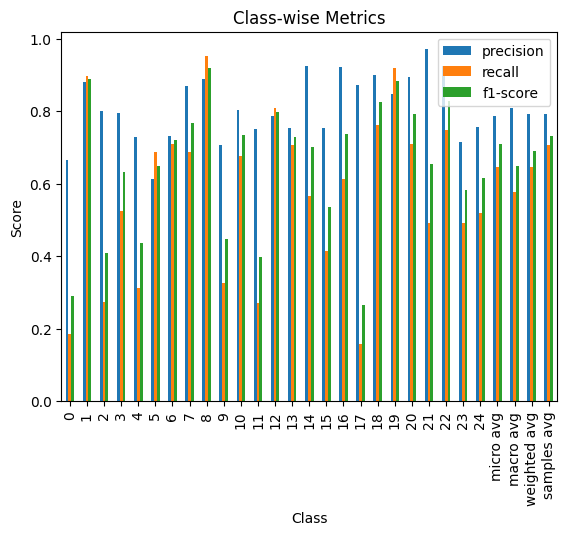

In [10]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Compute precision, recall and F1-score for each class
report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()

# Plot a bar chart of the metrics for each class
df[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title('Class-wise Metrics')
plt.xlabel('Class')
plt.ylabel('Score')
plt.savefig('class_metrics.jpg')

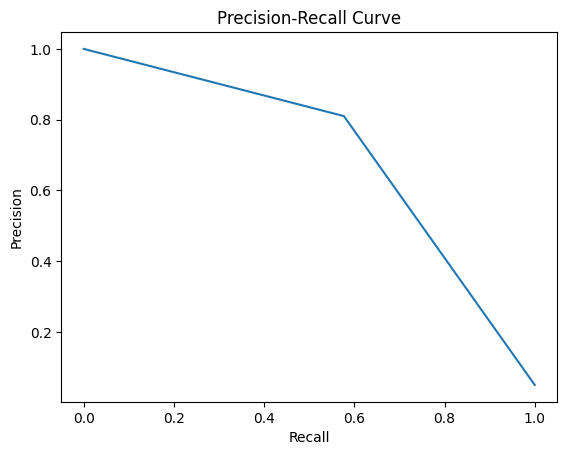

In [12]:
'''A precision and recall curve shows precision and recall values at all classification thresholds. 
It summarizes the trade off between precision and recall.'''

#Precision-Recall Curve:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt


# Convert numpy array to sparse matrix
y_test_sparse = csr_matrix(y_test)
y_pred_sparse = csr_matrix(y_pred)

y_pred_dense = np.asarray(y_pred_sparse.todense())
y_test_dense = np.asarray(y_test_sparse.todense())

# Compute precision, recall and threshold values for each class separately
precision = dict()
recall = dict()
thresholds = dict()
num_classes = 25     
for i in range(num_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test_dense[:, i], y_pred_dense[:, i])

# Compute the average precision and recall across all classes
avg_precision = np.mean([precision[i] for i in range(num_classes)], axis=0)
avg_recall = np.mean([recall[i] for i in range(num_classes)], axis=0)

# Plot the precision-recall curve
plt.plot(avg_recall, avg_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.savefig('class.jpg')




In [13]:
#chain done
# Using Classifier Chains
from sklearn.multioutput import ClassifierChain
import numpy as np


chains = [ClassifierChain(svc, order='random', random_state=i)
          for i in range(10)]

for chain in chains:
    chain.fit(x_train, y_train)

Y_pred_chains = np.array([chain.predict(X_test) for chain in
                          chains])

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_accuracy_score = accuracy_score(y_test, Y_pred_ensemble >= .5)
ensemble_recall_score = recall_score(y_test, Y_pred_ensemble >= .5, average='weighted')
ensemble_precision_score = precision_score(y_test, Y_pred_ensemble >= .5, average='weighted')
ensemble_f1_score = f1_score(y_pred, Y_pred_ensemble >= .5, average='weighted')
hamm = hamming_loss(Y_pred_ensemble >= .5, y_test)*100
print(ensemble_accuracy_score, ensemble_recall_score, ensemble_precision_score, ensemble_f1_score, hamm)


0.579072872949256 0.679547525053143 0.7938383029941994 0.7495812376673578 2.470049599389546


In [15]:
# Create a Logistic Regression classifier  done

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import time
# Use the classifier to make predictions on the test data

lr = LogisticRegression(max_iter=2000)
#svc = svm.SVC(kernel='linear', C=1, probability=True)
clf1 = OneVsRestClassifier(lr)
start = time.perf_counter()
clf1.fit(x_train, y_train)
end = time.perf_counter()

print(" Logistic Regress Model Time  : " + str(end - start) + " sec")

predictions_test = clf1.predict(X_test)

# Calculate accuracy on test data
print_score(predictions_test, clf1)
test_accuracy = accuracy_score(y_test, predictions_test)
print(f"Test accuracy: {test_accuracy:.2%}")

 Logistic Regress Model Time  : 17.292803600000298 sec
Clf:  OneVsRestClassifier
Accuracy score: 0.4849294162533384
Recall score: 0.5445642271484968
Precision score: 0.8671163419368887
Hamming loss: 2.6501335368180086
F1 score: 0.6934720481984796
---
Test accuracy: 48.49%


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Compute precision, recall and F1-score for each class
report = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()

# Plot a bar chart of the metrics for each class
df[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title('Class-wise Metrics')
plt.xlabel('Class')
plt.ylabel('Score')
plt.savefig('class_metrics.jpg')